In [1]:
import gzip
import matplotlib.pyplot as plt
import numpy as np
import struct
import os
import random
import tensorflow as tf
import keras
import keras.utils
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import TensorBoard
from keras import backend
import cv2 as cv

%matplotlib inline

In [9]:
## Load Data

In [2]:
dataset_path = '/home/swopnil/PycharmProjects/HandwritingRecognition/gzip/'
log_path = '/home/swopnil/PycharmProjects/HandwritingRecognition/logs/'

In [3]:
def read_idx(filename):
    print(f'Processing data from {filename}.')
    with gzip.open(filename, 'rb') as f:
        z, dtype, dim = struct.unpack('>HBB', f.read(4))
        print(f'Dimensions: {dim}')
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dim))
        print(f'Shape: {shape}')
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [4]:
def load_emnist():
    train_images = dataset_path + 'emnist-letters-train-images-idx3-ubyte.gz'
    train_labels = dataset_path + 'emnist-letters-train-labels-idx1-ubyte.gz'
    test_images = dataset_path + 'emnist-letters-test-images-idx3-ubyte.gz'
    test_labels = dataset_path + 'emnist-letters-test-labels-idx1-ubyte.gz'
    train_x = read_idx(train_images)
    train_y = read_idx(train_labels)
    test_x = read_idx(test_images)
    test_y = read_idx(test_labels)
    return (train_x, train_y, test_x, test_y)

In [5]:
raw_train_x, raw_train_y, raw_test_x, raw_test_y = load_emnist()

Processing data from /home/swopnil/PycharmProjects/HandwritingRecognition/gzip/emnist-letters-train-images-idx3-ubyte.gz.
Dimensions: 3
Shape: (124800, 28, 28)
Processing data from /home/swopnil/PycharmProjects/HandwritingRecognition/gzip/emnist-letters-train-labels-idx1-ubyte.gz.
Dimensions: 1
Shape: (124800,)
Processing data from /home/swopnil/PycharmProjects/HandwritingRecognition/gzip/emnist-letters-test-images-idx3-ubyte.gz.
Dimensions: 3
Shape: (20800, 28, 28)
Processing data from /home/swopnil/PycharmProjects/HandwritingRecognition/gzip/emnist-letters-test-labels-idx1-ubyte.gz.
Dimensions: 1
Shape: (20800,)


In [6]:
labels = 'abcdefghijklmnopqrstuvwxyz'

In [7]:
raw_train_x = np.array(raw_train_x)
raw_train_y = np.array(raw_train_y)
raw_test_x = np.array(raw_test_x)
raw_test_y = np.array(raw_test_y)

q


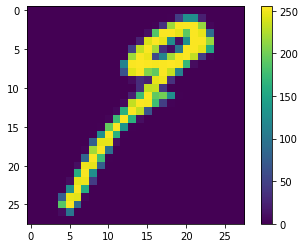

In [8]:
img_num = 30
plt.imshow(raw_train_x[img_num].T)
print(labels[raw_train_y[img_num] - 1])
plt.colorbar()
plt.show()

In [9]:
## Prepare data

In [9]:
print(f'train_x shape: {raw_train_x.shape}')
print(f'train_y shape: {raw_train_y.shape}')
print(f'test_x shape: {raw_test_x.shape}')
print(f'test_y shape: {raw_test_y.shape}')

train_x shape: (124800, 28, 28)
train_y shape: (124800,)
test_x shape: (20800, 28, 28)
test_y shape: (20800,)


In [10]:
img_height = len(raw_train_x[0])
img_width = len(raw_train_x[1])
input_shape = img_height * img_width
print(input_shape)

784


In [11]:
train_x = raw_train_x.reshape(len(raw_train_x), 28, 28)
print(len(raw_train_x))
print(train_x[20].shape)
test_x = raw_test_x.reshape(len(raw_test_x), 28, 28)
print(test_x[20].shape)

124800
(28, 28)
(28, 28)


Process Complete: Rotated and reversed test and train images!


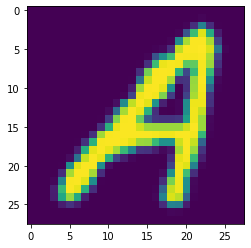

In [12]:
#for train data
for t in range(124800):
    train_x[t]=np.transpose(train_x[t])
    
#checking
plt.imshow(train_x[0])
plt.show

#for test data  
for t in range(20800):
    test_x[t]=np.transpose(test_x[t])

#checking
plt.imshow(test_x[1])
plt.show

print('Process Complete: Rotated and reversed test and train images!')

In [54]:
## Normalize

In [13]:
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
print(train_x.dtype)

float32


In [14]:
train_x /= 255
test_x /= 255


q


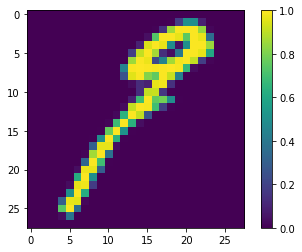

In [15]:
%matplotlib inline
img_num = 30
plt.imshow(train_x.reshape(len(train_x), 28, 28)[img_num])
print(labels[raw_train_y[img_num] - 1])
plt.colorbar()
plt.show()

g


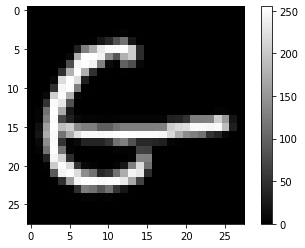

In [16]:
%matplotlib inline
img_num = 5000
plt.imshow(raw_test_x.reshape(len(test_x), 28, 28)[img_num], cmap='gray')
print(labels[raw_test_y[img_num] - 1])
plt.colorbar()
plt.show()

In [17]:
labels = 'abcdefghijklmnopqrstuvwxyz'
n_cat = len(labels) + 1

In [18]:
train_y = tf.keras.utils.to_categorical(raw_train_y)
test_y = tf.keras.utils.to_categorical(raw_test_y)


In [19]:
print(raw_train_y[2500])
print(train_y[2500])

8
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [20]:
train_x = raw_train_x.reshape(len(raw_train_x), input_shape)
print(len(raw_train_x))
print(train_x[20].shape)
test_x = raw_test_x.reshape(len(raw_test_x), input_shape)
print(test_x[20].shape)

124800
(784,)
(784,)


In [19]:
## Define and compile model

In [21]:
model = keras.models.Sequential()
model.add(Dense(64, input_dim=input_shape, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(27, activation='softmax'))

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
## Train the model

In [23]:
tensorboard = TensorBoard(log_dir=log_path, histogram_freq=0, write_graph=True)
callbacks_list = [tensorboard]

In [24]:
history = model.fit(train_x, train_y, validation_data=(test_x, test_y),epochs=20, batch_size=50, callbacks=callbacks_list)

Epoch 1/20
2496/2496 [==============================] - 5s 2ms/step - loss: 3.5328 - accuracy: 0.3706 - val_loss: 1.0475 - val_accuracy: 0.6874
Epoch 2/20
2496/2496 [==============================] - 4s 2ms/step - loss: 0.9396 - accuracy: 0.7198 - val_loss: 0.8008 - val_accuracy: 0.7586
Epoch 3/20
2496/2496 [==============================] - 4s 2ms/step - loss: 0.7297 - accuracy: 0.7778 - val_loss: 0.6868 - val_accuracy: 0.7936
Epoch 4/20
2496/2496 [==============================] - 4s 2ms/step - loss: 0.6166 - accuracy: 0.8128 - val_loss: 0.5993 - val_accuracy: 0.8238
Epoch 5/20
2496/2496 [==============================] - 4s 2ms/step - loss: 0.5558 - accuracy: 0.8315 - val_loss: 0.5767 - val_accuracy: 0.8258
Epoch 6/20
2496/2496 [==============================] - 4s 2ms/step - loss: 0.5271 - accuracy: 0.8385 - val_loss: 0.5501 - val_accuracy: 0.8372
Epoch 7/20
2496/2496 [==============================] - 4s 2ms/step - loss: 0.4967 - accuracy: 0.8478 - val_loss: 0.5371 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<ipython-input-25-b7118cfeb9f4>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('accuracy', dpi=500, facecolor='w', edgecolor='w',
<ipython-input-25-b7118cfeb9f4>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('accuracy', dpi=500, facecolor='w', edgecolor='w',


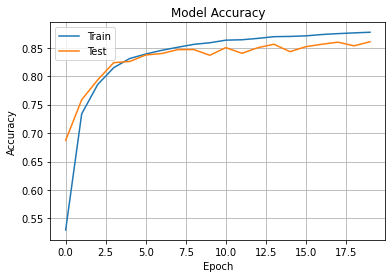

<ipython-input-25-b7118cfeb9f4>:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('loss', dpi=500, facecolor='w', edgecolor='w',
<ipython-input-25-b7118cfeb9f4>:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('loss', dpi=500, facecolor='w', edgecolor='w',


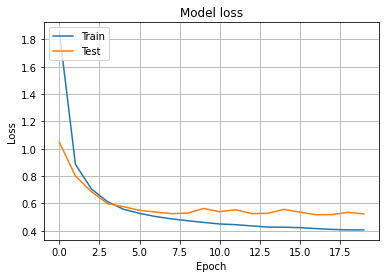

In [25]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.savefig('accuracy', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.savefig('loss', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
plt.show()


In [54]:
results = model.evaluate(test_x, test_y)

650/650 [==============================] - 1s 843us/step - loss: 0.5987 - accuracy: 0.8589


In [55]:
print(results[0]*100, results[1]*100)

59.86518859863281 85.88942289352417


In [56]:
model.save('digits.model')

INFO:tensorflow:Assets written to: digits.model/assets


In [65]:
english_letters = '0abcdefghijklmnopqrstuvwxyz'

[[0.0000000e+00 4.9953032e-03 8.9932677e-05 9.2694861e-01 3.3185410e-05
  1.7106874e-02 7.4412902e-03 3.5907336e-02 4.8888388e-10 1.2311780e-04
  7.1078148e-06 1.9923763e-04 2.2374266e-03 0.0000000e+00 5.9923183e-14
  1.5749899e-03 2.2776275e-04 1.7075039e-05 1.2140346e-03 3.0745906e-04
  1.2715283e-03 2.8216935e-04 0.0000000e+00 6.5423519e-25 5.0424963e-18
  1.6498251e-06 1.3904803e-05]]
prediction: c


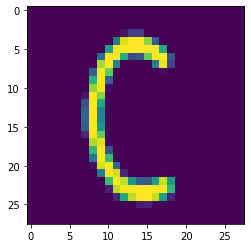

In [67]:
img = cv.imread('/home/swopnil/PycharmProjects/HandwritingRecognition/src/c.png')[:,:,0]
plt.imshow(img)
plt.show
prediction = model.predict(img.reshape(1, 784))
print(prediction)
print(f'prediction: {english_letters[np.argmax(prediction)]}')

a


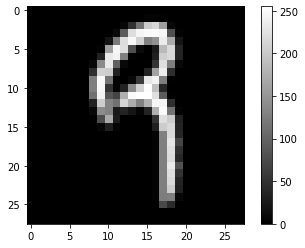

In [58]:
img_num = 30
plt.imshow(raw_test_x[img_num].T, cmap='gray')
print(labels[raw_test_y[img_num] - 1])
plt.colorbar()
plt.show()

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   4  21  32
  37  37  20   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   4  22 110 172 203 217 214 138  15   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  20  45 114 145 232
 252 254 254 232  93   6   0   0   0   0   0   0   

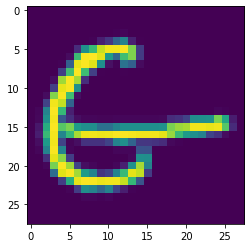

In [66]:
print(test_x[0])
print(test_x[0].shape)
ik = test_x[0].reshape(28, 28)

m = test_x[5000].reshape(28,28)
plt.imshow(m)
plt.show
prediction = model.predict(test_x[5000].reshape(1,784))
print(prediction)
print(f'prediction: {english_letters[np.argmax(prediction)]}')

In [1]:
## word segmentation 

(89, 415, 3)
(356, 2075, 3)


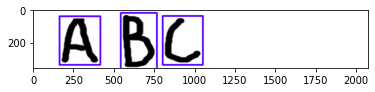

In [68]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

image = cv.imread('example.png')
height, width, depth = image.shape
print(image.shape)

image = cv.resize(image, dsize=(width*5, height*4), interpolation=cv.INTER_CUBIC)
print(image.shape)

gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
ret,thresh = cv.threshold(gray,127,255,cv.THRESH_BINARY_INV)

kernel = np.ones((5,5), np.uint8)
img_dilation = cv.dilate(thresh, kernel, iterations=1)

gsblur=cv.GaussianBlur(img_dilation,(5,5),0)

ctrs, hier = cv.findContours(gsblur.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
m = list()
#sort contours
sorted_ctrs = sorted(ctrs, key=lambda ctr: cv.boundingRect(ctr)[0])
pchl = list()
dp = image.copy()
for i, ctr in enumerate(sorted_ctrs):
    # Get bounding box
    x, y, w, h = cv.boundingRect(ctr)
    cv.rectangle(dp,(x-10,y-10),( x + w + 10, y + h + 10 ),(90,0,255),9)
plt.imshow(dp)

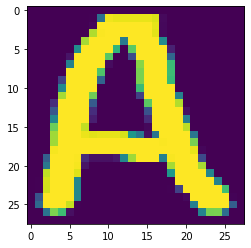

1


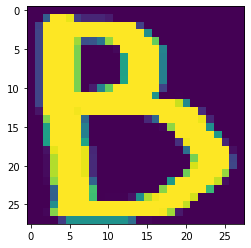

2


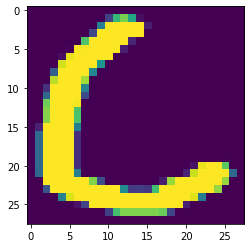

3
Predicted String:abc


In [63]:
characters = '0abcdefghijklmnopqrstuvwxyz'
prediction = list()
predicted_word = ''

for i, ctr in enumerate(sorted_ctrs):
    # Get bounding box
    x, y, w, h = cv.boundingRect(ctr)
    # Getting ROI
    roi = image[y-10:y+h+10, x-10:x+w+10]
    roi = cv.resize(roi, dsize=(28,28), interpolation=cv.INTER_CUBIC)
    roi = cv.cvtColor(roi,cv.COLOR_BGR2GRAY)
    roi = cv.bitwise_not(roi)
    plt.imshow(roi)
    plt.show()
    
    roi = np.array(roi)
    t = np.copy(roi)
    t = t.reshape(1,784)
    m.append(roi)
    pred = model.predict(t)
    pred = np.argmax(pred)
    print(pred)
    prediction.append(pred)
    predicted_word += characters[pred]

print(f'Predicted String:{predicted_word}')
